### Pytorch Neural Network Classification

In [68]:
%pip install scikit-learn pandas

Note: you may need to restart the kernel to use updated packages.


In [69]:
import sklearn
from sklearn.datasets import make_circles

In [70]:
n_samples = 1000
X,y = make_circles(n_samples,noise=0.05,random_state=42)

In [71]:
len(X),len(y)

(1000, 1000)

In [72]:
print(f"First Five Samples Of X {X[:5]}")
print(f"First Five Samples Of y {y[:5]}")

First Five Samples Of X [[ 0.74220688  0.24668576]
 [-0.7340323   0.16869164]
 [-0.82985872  0.22195899]
 [-0.42913559  0.67223019]
 [ 0.44560223 -0.89493556]]
First Five Samples Of y [1 1 1 1 0]


In [73]:
import pandas as pd
circles = pd.DataFrame({"X1":X[:,0],
                        "X2":X[:,1],
                        "label":y})
circles.head(10)

,X1,X2,label
0,0.742207,0.246686,1
1,-0.734032,0.168692,1
2,-0.829859,0.221959,1
3,-0.429136,0.672230,1
4,0.445602,-0.894936,0
5,-0.469885,0.708037,1
6,-0.016045,0.805623,1
7,0.759623,0.159526,1
8,-0.175692,-0.799837,1
9,-0.110616,1.042207,0


### Visualize

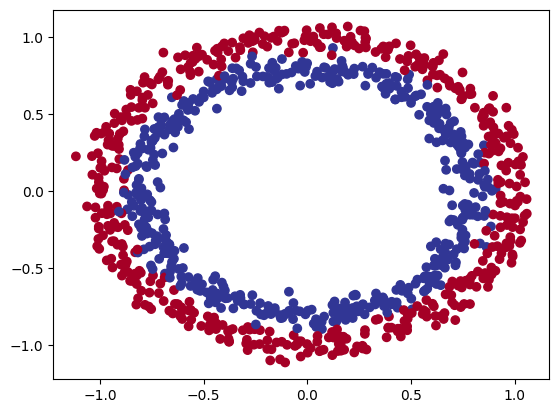

In [74]:
import matplotlib.pyplot as plt
plt.scatter(x=circles['X1'],
            y=circles['X2'],
            c=circles['label'],
            cmap='RdYlBu')

### Check Input And Output Shapes

In [75]:
X.shape,y.shape

((1000, 2), (1000,))

In [76]:
X_sample = X[0]
y_sample = y[0]
print(f"Values of X sample {X_sample} and y sample {y_sample}")
print(f"Shape of X sample {X_sample.shape} and y sample {y.shape}")

Values of X sample [0.74220688 0.24668576] and y sample 1
Shape of X sample (2,) and y sample (1000,)


In [77]:
import torch

In [78]:
# Turn Data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [79]:
# Create Train Test Split
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 test_size=0.2,
                                                 random_state=42)

In [80]:
len(X_train),len(X_test),len(y_train),len(y_test)

(800, 200, 800, 200)

### Building The Model

In [81]:
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [82]:
X_train

tensor([[ 0.6772, -0.4456],
        [ 0.6030, -0.7328],
        [-1.0219, -0.1066],
        ...,
        [ 0.0011, -1.0504],
        [ 1.0259,  0.1799],
        [ 0.5597, -0.5673]])

In [83]:
from sklearn import datasets
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,out_features=128)
        self.relu1 = nn.ReLU() # Add ReLU activation between layers
        self.layer_2 = nn.Linear(in_features=128,out_features=256)
        self.relu2 = nn.ReLU()
        self.layer_3 = nn.Linear(in_features=256,out_features=128)
        self.relu3 = nn.ReLU()
        self.layer_4 = nn.Linear(in_features=128,out_features=1)
    def forward(self,x):
        return self.layer_2(self.layer_1(x))

In [84]:
linear = CircleModelV0().to(device)
linear

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=128, bias=True)
  (relu1): ReLU()
  (layer_2): Linear(in_features=128, out_features=256, bias=True)
  (relu2): ReLU()
  (layer_3): Linear(in_features=256, out_features=128, bias=True)
  (relu3): ReLU()
  (layer_4): Linear(in_features=128, out_features=1, bias=True)
)

In [85]:
linear.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802],
                      [-0.3258, -0.0829],
                      [-0.2872,  0.4691],
                      [-0.5582, -0.3260],
                      [-0.1997, -0.4252],
                      [ 0.0667, -0.6984],
                      [ 0.6386, -0.6007],
                      [ 0.5459,  0.1177],
                      [-0.2296,  0.4370],
                      [ 0.1102,  0.5713],
                      [ 0.0773, -0.2230],
                      [ 0.1900, -0.1918],
                      [ 0.2976,  0.6313],
                      [ 0.4087, -0.3091],
  

In [86]:
#Make Predictions
with torch.inference_mode():
    untrained_preds = linear(X_test.to(device))
print(f"Length Of Predictions Samples {len(untrained_preds)},Shape {untrained_preds.shape}")
print(f"Length Of Test Samples {len(X_test)} Shape {X_test.shape}")
print(f"\nFirst 10 Predictions:\n {(untrained_preds[30:70])}")
print(f"\nFirst 10 Labels:\n {y_test[:10]}")

Length Of Predictions Samples 200,Shape torch.Size([200, 256])
Length Of Test Samples 200 Shape torch.Size([200, 2])

First 10 Predictions:
 tensor([[-0.2218,  0.4269, -0.0926,  ...,  0.6648,  0.3160, -0.4243],
        [-0.2140,  0.4310, -0.2484,  ...,  0.6896,  0.3064, -0.4055],
        [-0.3141, -0.0632, -0.0070,  ...,  0.6350,  0.2610,  0.0305],
        ...,
        [-0.2035,  0.5733,  0.0870,  ...,  0.6410,  0.3457, -0.5902],
        [-0.2482,  0.2501, -0.2144,  ...,  0.6783,  0.2862, -0.2380],
        [-0.2143,  0.5270,  0.1408,  ...,  0.6310,  0.3435, -0.5539]])

First 10 Labels:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [87]:
#Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
linear_optimizer = torch.optim.SGD(params=linear.parameters(),
                                   lr=0.001)

In [88]:
def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

### Training The Model

In [89]:
linear.eval()
with torch.inference_mode():
    y_logits = linear(X_test.to(device))[:5]
y_logits

tensor([[-0.3137, -0.0475,  0.0464,  ...,  0.6271,  0.2664,  0.0077],
        [-0.2616,  0.1843, -0.1812,  ...,  0.6709,  0.2803, -0.1801],
        [-0.3809, -0.2820,  0.5957,  ...,  0.5321,  0.2731,  0.1510],
        [-0.2918,  0.0300, -0.1286,  ...,  0.6574,  0.2646, -0.0406],
        [-0.2886,  0.2231,  0.5711,  ...,  0.5526,  0.3339, -0.3270]])

In [90]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4222, 0.4881, 0.5116,  ..., 0.6518, 0.5662, 0.5019],
        [0.4350, 0.5459, 0.4548,  ..., 0.6617, 0.5696, 0.4551],
        [0.4059, 0.4300, 0.6447,  ..., 0.6300, 0.5679, 0.5377],
        [0.4276, 0.5075, 0.4679,  ..., 0.6587, 0.5658, 0.4898],
        [0.4283, 0.5555, 0.6390,  ..., 0.6347, 0.5827, 0.4190]])

In [91]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(linear(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])


tensor([[0., 0., 1.,  ..., 1., 1., 1.],
        [0., 1., 0.,  ..., 1., 1., 0.],
        [0., 0., 1.,  ..., 1., 1., 1.],
        [0., 1., 0.,  ..., 1., 1., 0.],
        [0., 1., 1.,  ..., 1., 1., 0.]])

In [92]:
if(device == 'cuda'):
    torch.cuda.manual_seed(42)
else:
    torch.manual_seed(42)
###Training Loop
epochs = 100

y_test, y_train = y_test.to(device), y_train.to(device)
X_train, X_test = X_train.to(device), X_test.to(device)

###Tracking Info

epochs_count = []
loss_count = []
test_loss_count = []

for epoch in range(epochs):
    #Sets the model to training mode 
    linear.train() #-> train mode in pytorch sets required gradients to require gradients

    # 1.Forward pass
    y_logits = linear(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) #turns logits -> pred probs -> pred labels
    
    # 2.Calculate The Loss
    loss = loss_fn(y_logits,y_train)
    acc = accuracy_fn(y_true=y_train,y_pred=y_pred)

    # 3.Optimizer Zero Grad
    linear_optimizer.zero_grad()

    # 4. Perform Backpropagation on the loss with respect to the model parameters
    loss.backward()

    # 5.Step the optimizer
    linear_optimizer.step()

    # Testing
    linear.eval() # -> turns off gradient tracking
    with torch.inference_mode():
        test_logits = linear(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits,y_test)
        test_accuracy = accuracy_fn(y_true=y_test,y_pred=test_pred)
    
    if epoch % 10 == 0:
        epochs_count.append(epoch)
        loss_count.append(loss)
        test_loss_count.append(test_loss)
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_accuracy:.2f}%")

ValueError: Target size (torch.Size([800])) must be the same as input size (torch.Size([800, 256]))

### To do so, we'll write some code to download and import the helper_functions.py script from the Learn PyTorch for Deep Learning repo.

It contains a helpful function called plot_decision_boundary() which creates a NumPy meshgrid to visually plot the different points where our model is predicting certain classes.

We'll also import plot_predictions() which we wrote in notebook 01 to use later.

In [ ]:
%pip install requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [requests]2/5 [charset_normalizer]
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

In [ ]:
import matplotlib.pyplot as plt

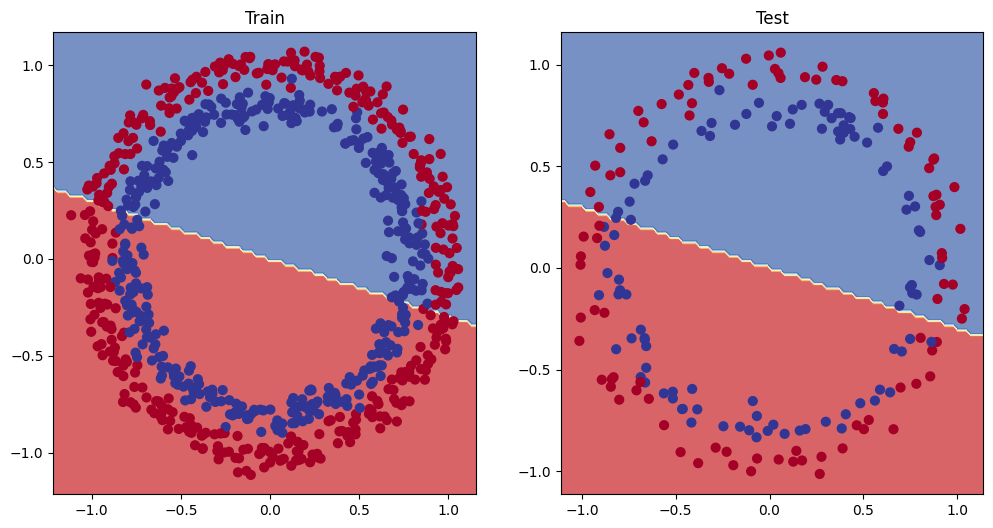

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(linear, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(linear, X_test, y_test)

### Improving The Model